# Shrink Spot Model examples

### Load Modules

In [1]:
import ssms
import hssm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import bambi as bmb
import arviz as az
import uuid

from hssm.distribution_utils.onnx import make_jax_logp_funcs_from_onnx

from hssm.distribution_utils.dist import (
	make_distribution,
	make_hssm_rv,
	make_likelihood_callable,
)

## Model 1: Simple Shrink Spot

### Forward simulator

In [2]:
from functools import partial

from ssms.basic_simulators.simulator import simulator
from hssm.utils import decorate_atomic_simulator, ssms_sim_wrapper

# We are using a basic simulator from the `ssm-simulators` package and follow a simple two step pattern
# 1. We use the partial() function to pre define some settings of the simulator (this could have been done e.g. by manually wrapping the simulator in a function that applies those defaults)
# 2. We use the `decorate_atomic_simulator` function to wrap the simulator in a way that allows us to use it in the `make_hssm_rv` function 
# (in essence, the decorator just adds some attributes to the simulator object, which will be used internally to construct the `PyTensor` random variable)

# Step 1:
simulator_with_predefined_settings = partial(
    ssms_sim_wrapper, simulator_fun=ssms.basic_simulators.simulator.simulator, model="shrink_spot_simple"
)

# Step 2:
decorated_simulator = decorate_atomic_simulator(
    model_name="shrink_spot_simple", choices=[-1, 1], obs_dim=2
)(simulator_with_predefined_settings)

### Construct `PyTensor` RandomVariable

In [3]:
ShrinkSpotRV = make_hssm_rv(simulator_fun = decorated_simulator,
                            list_params = ['a', 'z', 't', 'ptarget',
                                           'pouter', 'r', 'sda'],
                            lapse = None)

In [4]:
# Testing forward simulation through the rng_fn
ShrinkSpotRV.rng_fn(np.random.default_rng(123),
                    np.array([1.5]),
                    np.array([0.5]),
                    np.array([0.3]),
                    np.array([3.0]),
                    np.array([-5.5]),
                    np.array([0.03]),
                    np.array([1.0]),
                    10)

array([[ 0.54862487, -1.        ],
       [ 0.73780537, -1.        ],
       [ 0.76293713, -1.        ],
       [ 1.94404161, -1.        ],
       [ 0.76269156, -1.        ],
       [ 0.97971934, -1.        ],
       [ 0.87753642, -1.        ],
       [ 0.79769927, -1.        ],
       [ 0.64235216, -1.        ],
       [ 0.66356438, -1.        ]])

### Specify log-likelihood

We can simply start with the `.onnx` model coming out of the oscar pipeline. (Even simpler will be to straight upload to / download this from HuggingFace).

In [5]:
# Networks for full shrink spot model (unused for now)
#network_path = r"test_files/new_bounds_shrink_spot_lan_eab5ad7c5e7711efa296a0423f3e9b4e_torch_model.onnx"

# Network 
network_path = r"../data/torch_models/shrink_spot_simple" \
               r"/shrink_spot_simple_lan_0af81cb2bef111ef851fa0423f3e9b72_torch_model.onnx"

shrinkspot_logp_jax_op = make_likelihood_callable(loglik = network_path,
                                                  loglik_kind = "approx_differentiable",
                                                  backend = "jax",
                                                  params_is_reg = [False, False, False,
                                                                   False, False, False, False],
                                                  params_only = False)

In [6]:
# Testing the logp op
shrinkspot_logp_jax_op(np.zeros((100, 2)),
                       np.zeros(1),
                       np.zeros(1),
                       np.zeros(1),
                       np.zeros(1),
                       np.zeros(1),
                       np.zeros(1),
                       np.zeros(1)).eval()

array([-5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15930302,
       -5.15930302, -5.15930302, -5.15930302, -5.15930302, -5.15

### Construct proper `PyMC` distribution

Using the `make_distribution()` helper function, we can combine our our PyTensor random variables (which we use for forward simulation), and our `JAX` likelihood (which we need for inference), to
produce a proper PyMC distribution.

In [7]:
SimpleShrinkSpot = make_distribution(
                        rv = ShrinkSpotRV,
                        loglik = shrinkspot_logp_jax_op,
                        list_params = ['a', 'z', 't', 'ptarget', 'pouter', 'r', 'sda'],
                        bounds =  {
                            "a": (0.3, 3.0),
                            "z": (0.1, 0.9),
                            "t": (0.001, 2),
                            "ptarget": (2.0, 5.5),
                            "pouter": (-5.5, 5.5),
                            "r": (0.01, 0.05),
                            "sda": (1, 3),
                        },
)

In [8]:
# simulate some data
data_1 = hssm.simulate_data(model = "shrink_spot_simple",
                            theta = dict(a = 1.5,
                                         z = 0.5,
                                         t = 0.3,
                                         ptarget = 3.0,
                                         pouter = -5.5,
                                         r = 0.03,
                                         sda = 1.0),
                           size = 1000)

### PyMC Model

In [9]:
with pm.Model() as model_1:
    # data
    y = pm.Data("y", data_1)

    # priors
    a = pm.Uniform("a", lower = 0.3, upper = 3.0)
    t = pm.Weibull("t", alpha = 3.0, beta = 0.5)
    z = pm.Beta("z", alpha = 10., beta = 10.)
    r = pm.Uniform("r", lower = 0.01, upper = 0.05)
    sda = pm.Uniform("sda", lower = 1, upper = 3)
    ptarget = pm.Uniform("ptarget", lower = 2.0, upper = 5.5)
    pouter = pm.Uniform("pouter", lower = -5.5, upper = 5.5)
    
    # likelihood term
    obs = SimpleShrinkSpot("obs", a = a, z = z, t = t,
                           ptarget = ptarget, pouter = pouter,
                           r = r, sda = sda,
                           observed = y)


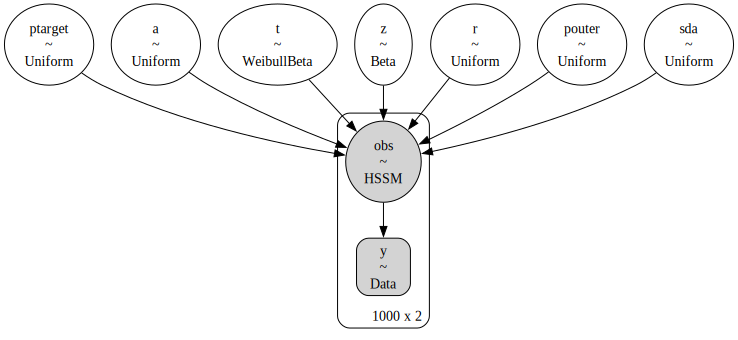

In [10]:
pm.model_to_graphviz(model_1)

In [11]:
with model_1:
    idata_1 = pm.sample(tune = 500,
                        draws = 500,
                        chains = 2,
                        nuts_sampler="numpyro")

/Users/afengler/miniconda3/envs/hssm519/lib/python3.11/site-packages/pymc/sampling/jax.py:437: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1000/1000 [19:25<00:00,  1.17s/it, 1023 steps of size 4.68e-04. acc. prob=0.99]
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Sample diagnostics

In [12]:
az.summary(idata_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.475,0.197,1.172,1.773,0.131,0.109,3.0,11.0,2.20
pouter,-4.046,1.418,-5.500,-2.263,0.992,0.838,3.0,11.0,2.20
ptarget,2.964,0.279,2.307,3.251,0.136,0.105,5.0,186.0,1.76
r,0.022,0.011,0.010,0.033,0.007,0.006,3.0,27.0,1.88
sda,1.585,0.581,1.000,2.179,0.408,0.344,3.0,39.0,2.08
t,0.329,0.077,0.223,0.423,0.052,0.044,3.0,11.0,2.23
z,0.437,0.081,0.305,0.567,0.054,0.045,3.0,11.0,2.23


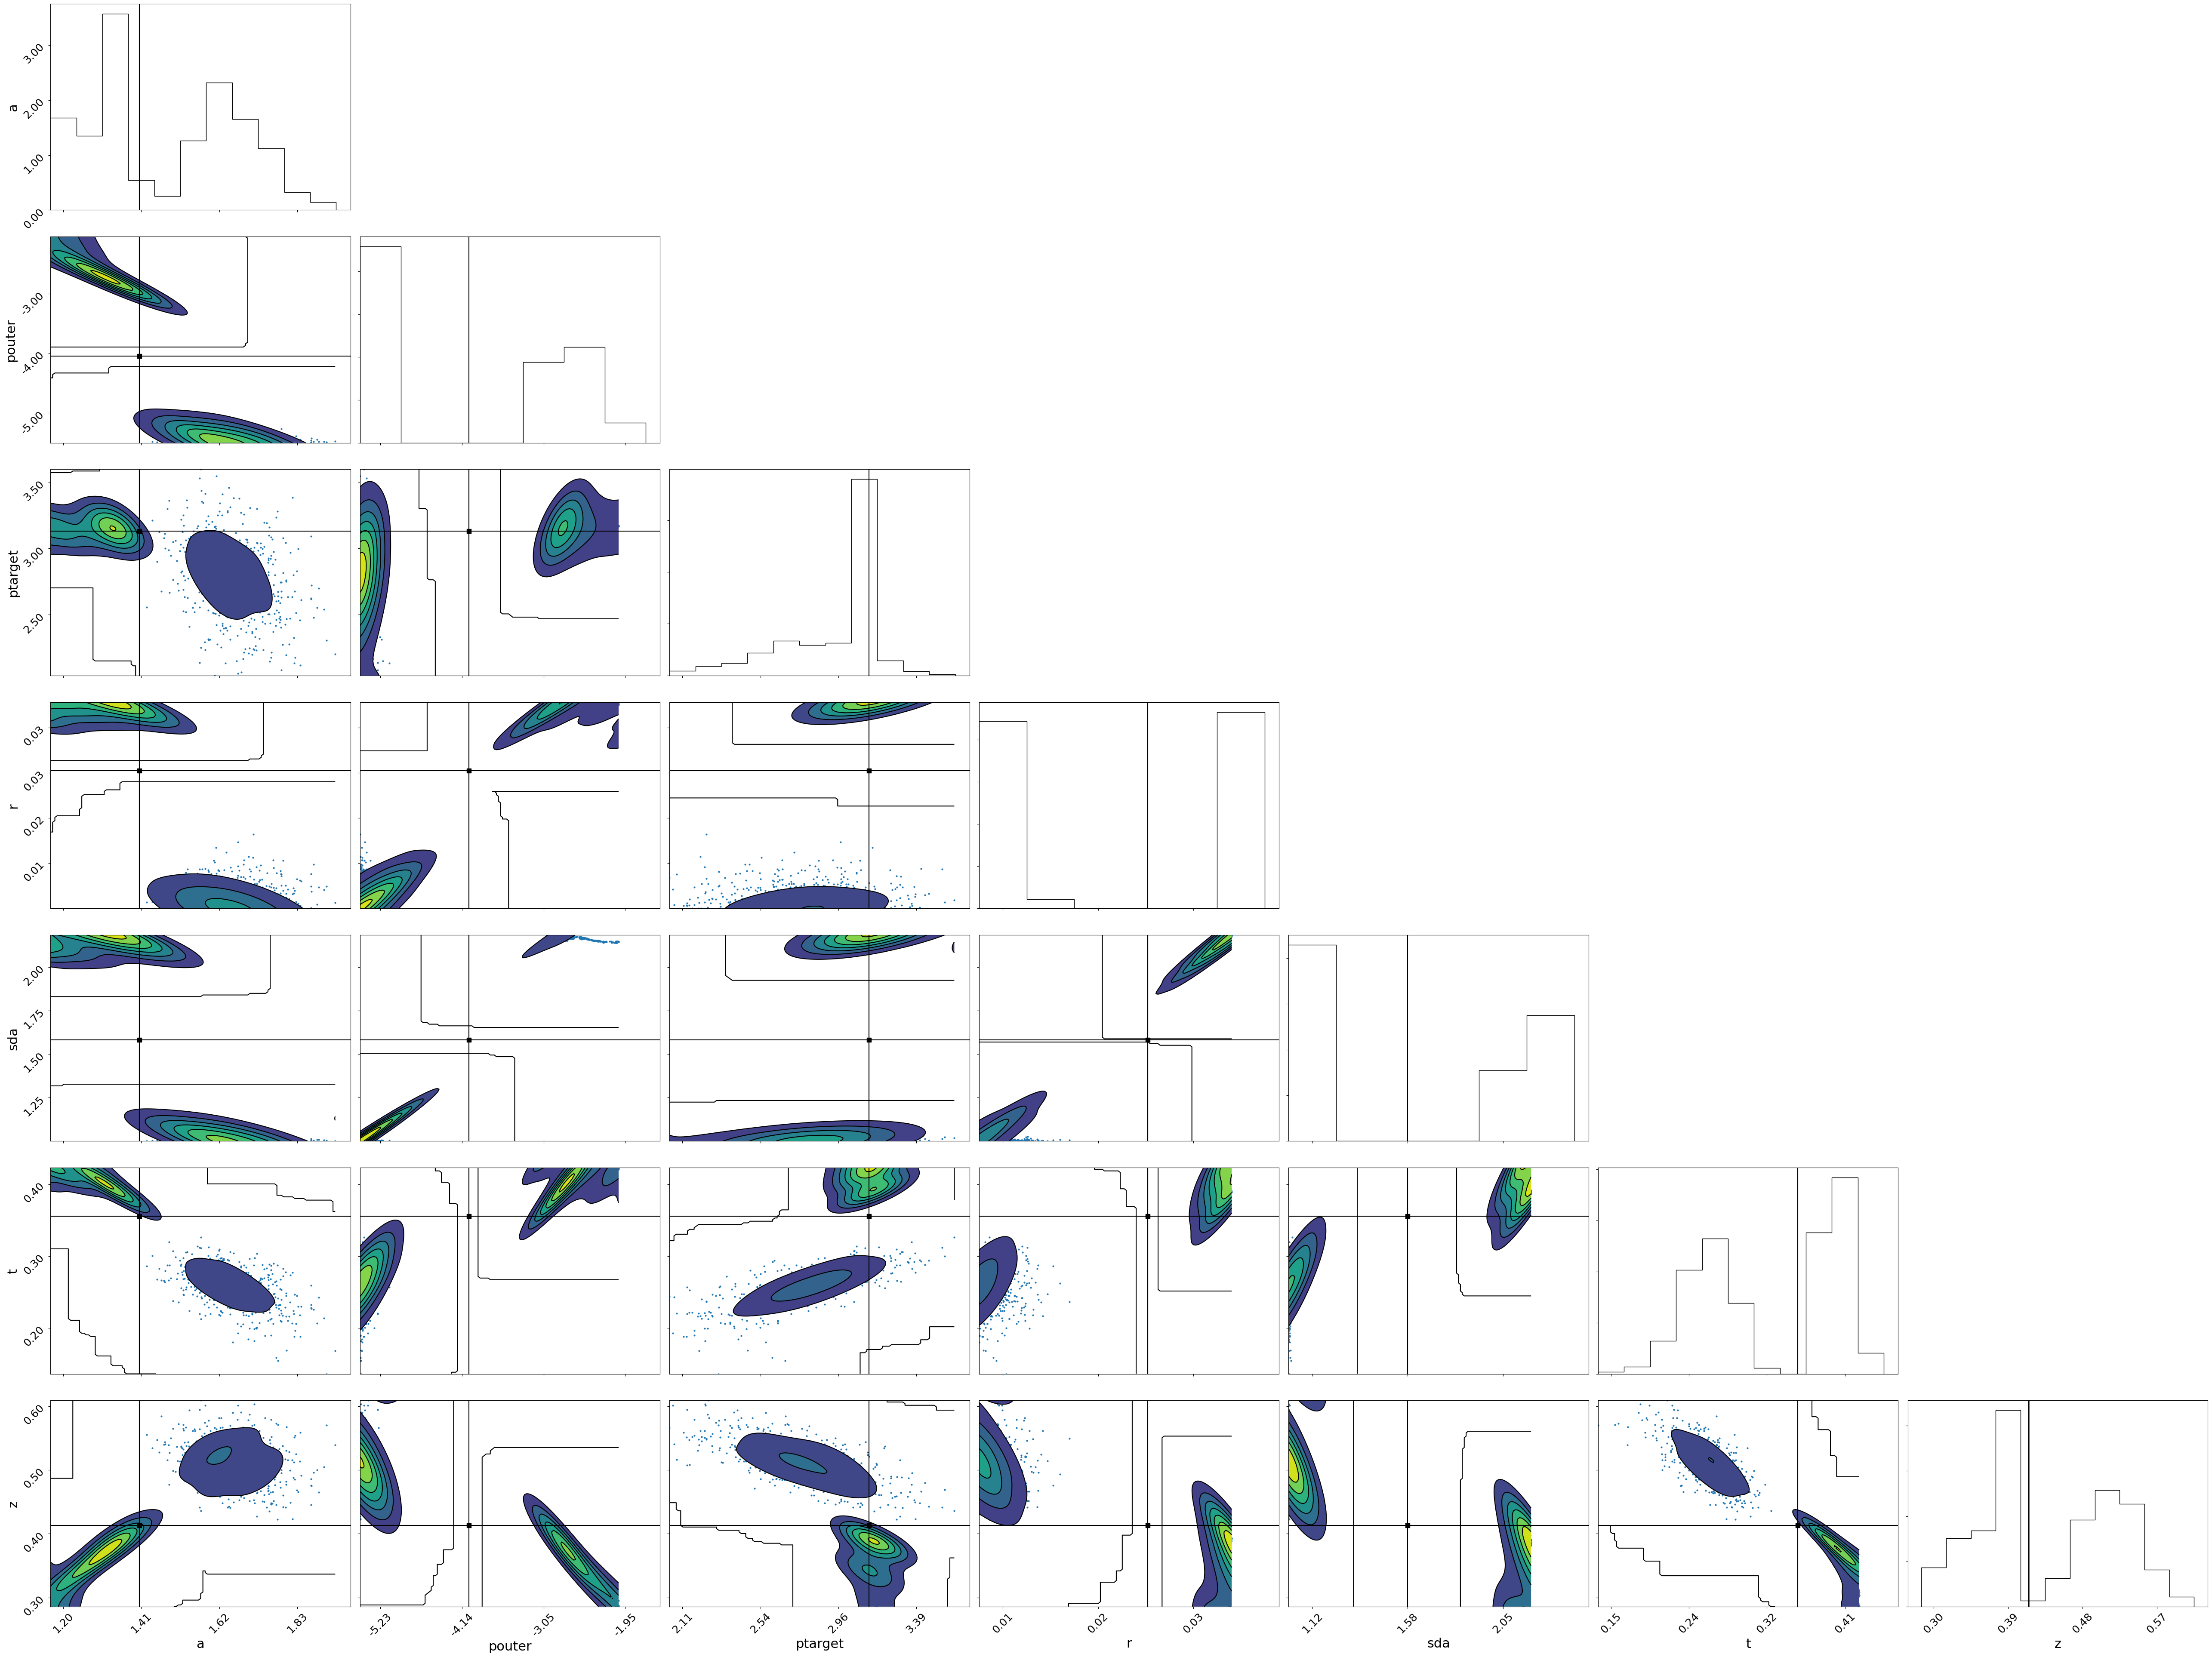

In [13]:
# Pair plot
ax = az.plot_pair(idata_1,
                  kind=['kde', 'scatter'],
                  marginals=True,
                  kde_kwargs={"fill_last": False},
                  marginal_kwargs={"kind": "hist",
                                    "color": "black",
                                    "hist_kwargs": {"histtype": "step"},
                  },
                  point_estimate="median");


# Some extra formatting
[ax_i.tick_params(axis='x', rotation=45, labelsize=18) or \
 ax_i.tick_params(axis='y', rotation=45, labelsize=18) or \
 ax_i.locator_params(axis='x', nbins=5)  or \
 ax_i.locator_params(axis='y', nbins=5)  or \
 ax_i.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) or \
 ax_i.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) or \
 ax_i.set_xlabel(ax_i.get_xlabel(), fontsize=22)
 for ax_i in ax.ravel() if ax_i is not None]

# Then handle y-labels separately for the leftmost plots
[ax[i, 0].set_ylabel(ax[i, 0].get_ylabel(), fontsize=22) 
 for i in range(len(ax)) if ax[i, 0] is not None]
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

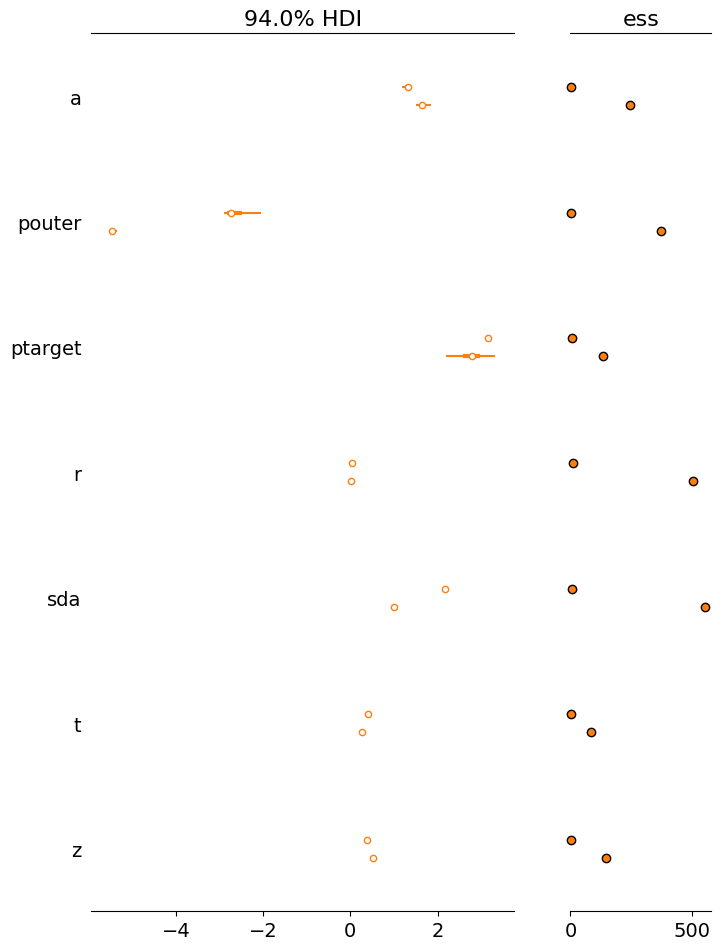

In [14]:
az.plot_forest(idata_1,
               colors = "C1",
               ess=True)

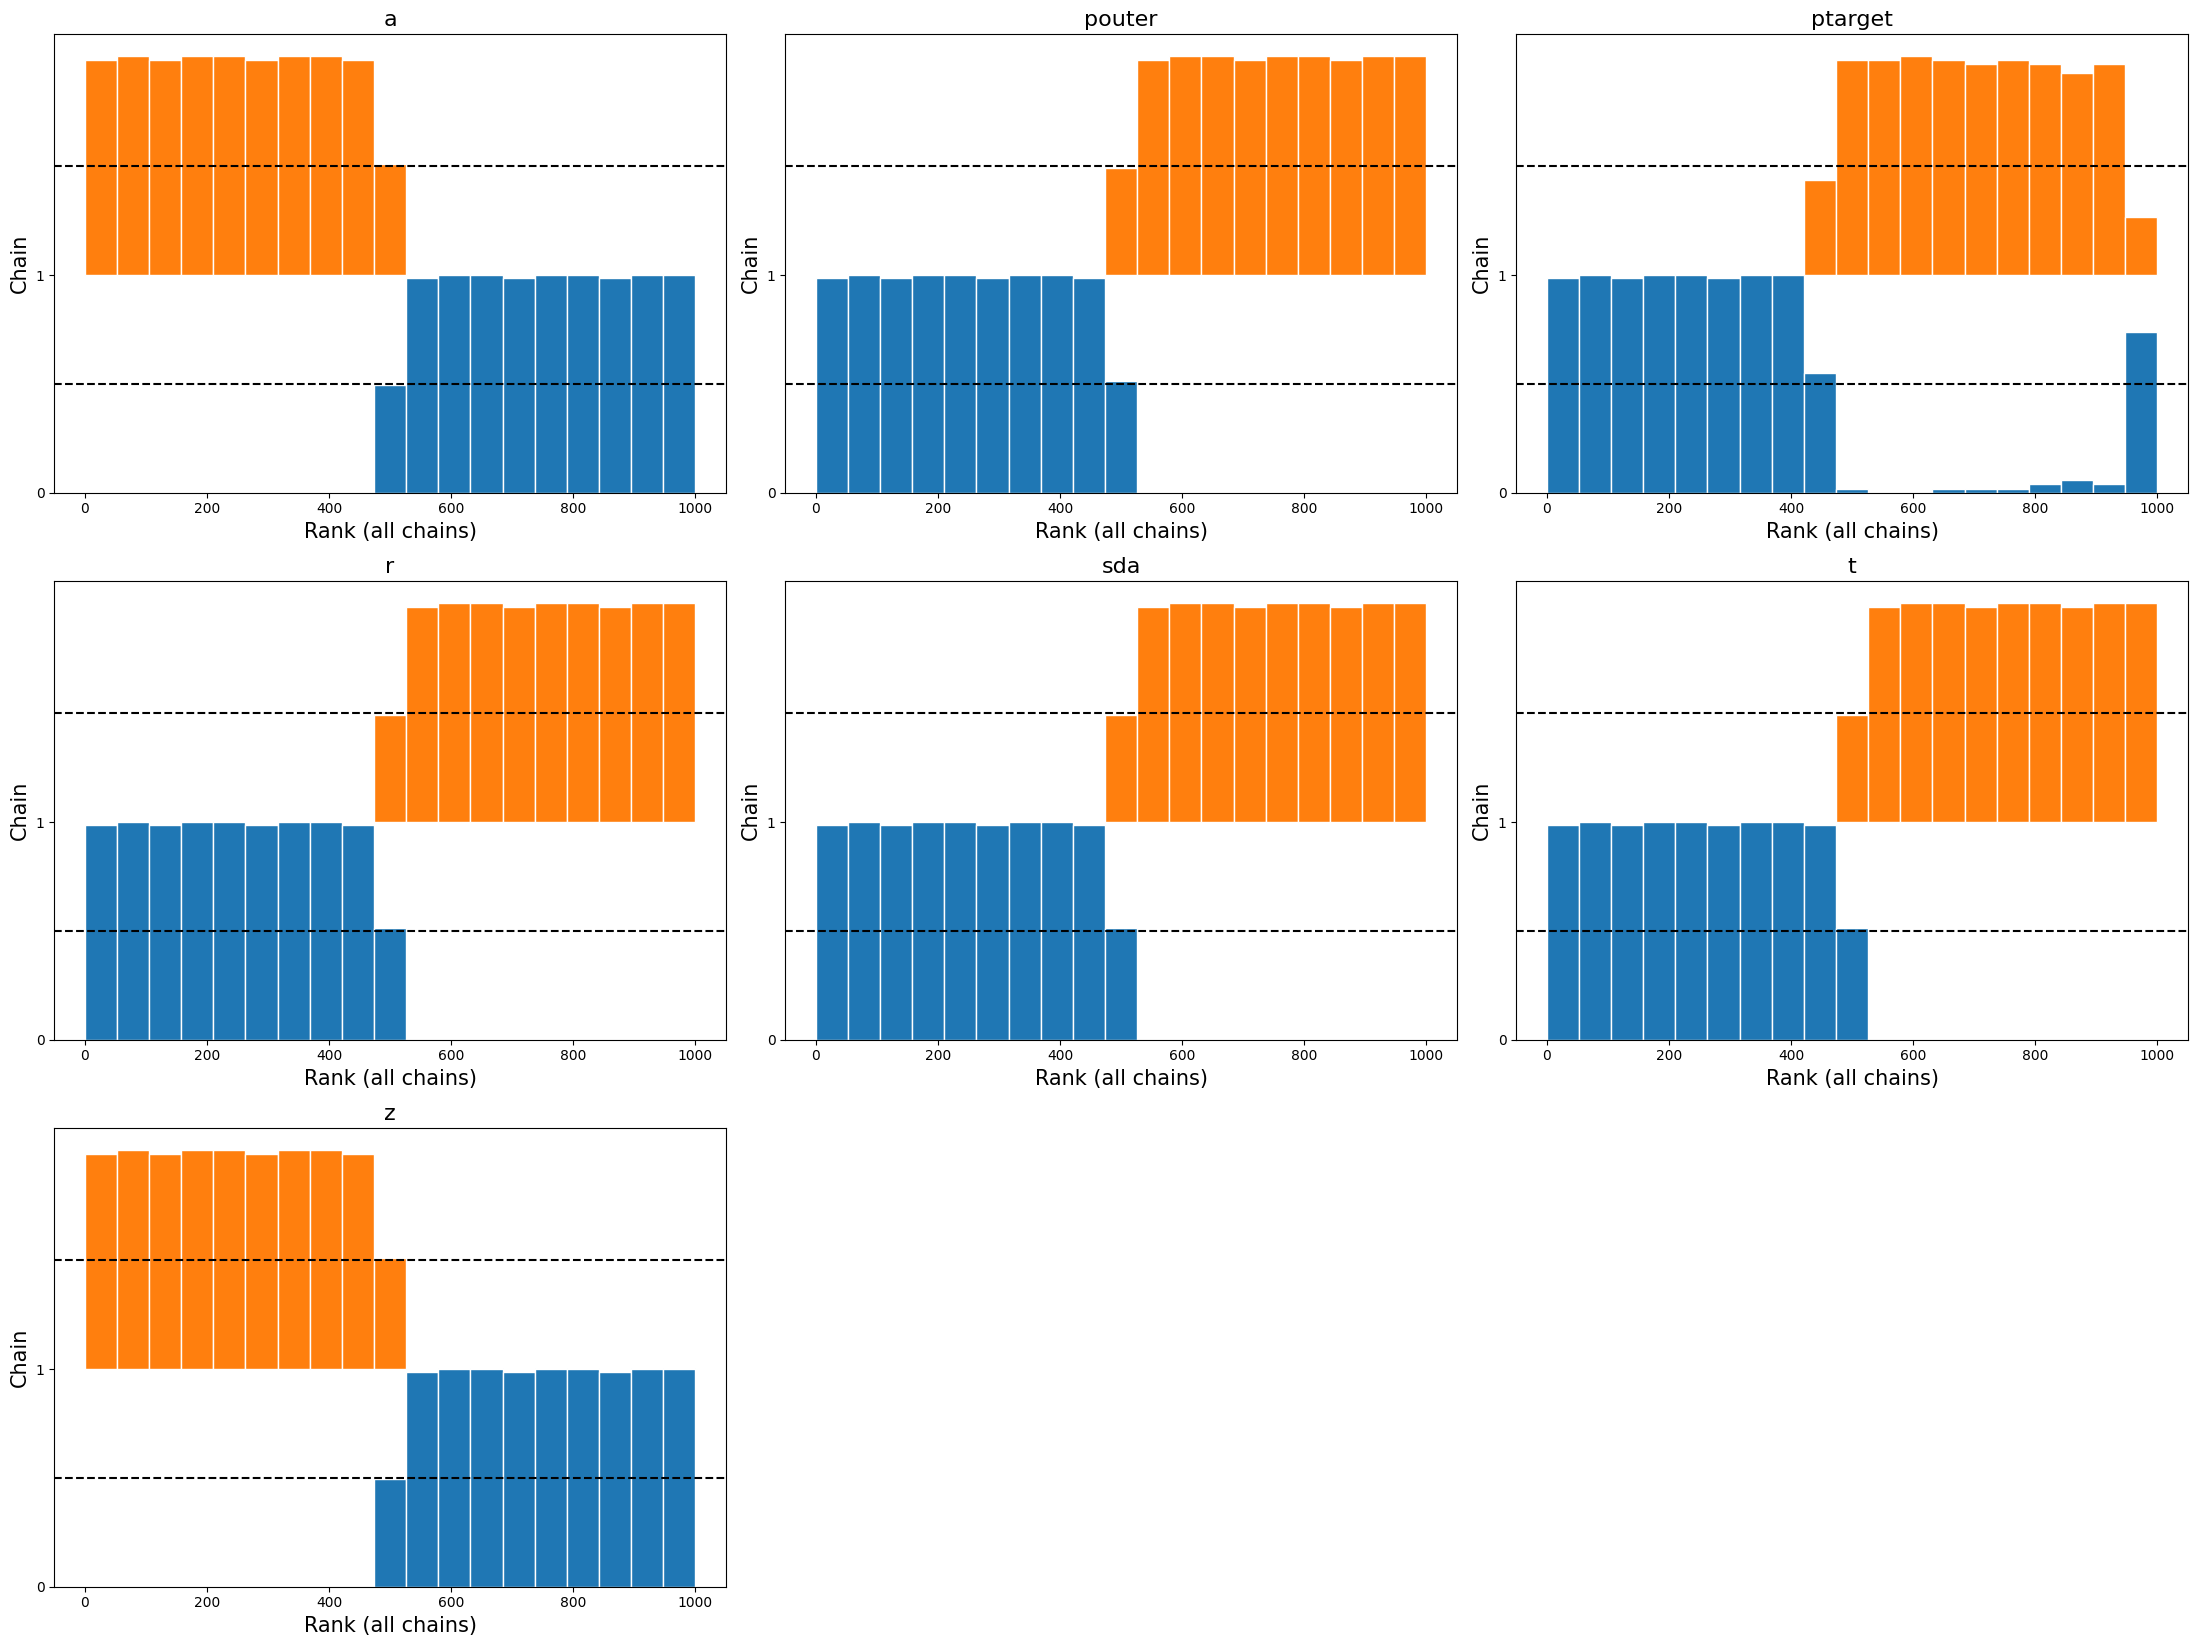

In [15]:
az.plot_rank(idata_1)
plt.tight_layout()

## Model 2: Simplified shrink spot with parameter sharing

Why do we care? We discovered some very problematic parameter trade-offs and non-identifiabilities with the other model.

### Specify log-likelihood

We can simply start with the `.onnx` model coming out of the oscar pipeline. (Even simpler will be to straight upload to / download this from HuggingFace).

Now need to make a new `make_likelihood_callable()` helper function to construct a `PyTensor` wrapped likelihood.
Why? Because we will want to define one of our parameters as a trial-dependent regression.

In [16]:
shrinkspot_2_logp_jax_op_simple = make_likelihood_callable(loglik = network_path,
                                                           loglik_kind = "approx_differentiable", # Because we are using a network that is trained to approximate a likelihood
                                                           backend = "jax", # Basically our default backend
                                                           params_is_reg = [False, False,
                                                                            False, False,
                                                                            True, False,
                                                                            False], # At point of construction, we have to decide which parameters will be the target of regressions
                                                           params_only = False)

### Construct proper `PyMC` distribution

Using the `make_distribution()` helper function, we can combine our our PyTensor random variables (which we use for forward simulation), and our `JAX` likelihood (which we need for inference), to
produce a proper PyMC distribution.


In [17]:
SimpleShrinkSpot2 = make_distribution(
                        rv = ShrinkSpotRV,
                        loglik = shrinkspot_2_logp_jax_op_simple,
                        list_params = ssms.config.model_config["shrink_spot_simple"]["params"],
                        bounds =  {ssms.config.model_config["shrink_spot_simple"]["params"][i]: 
                                        [ssms.config.model_config["shrink_spot_simple"]["param_bounds"][0][i],
                                            ssms.config.model_config["shrink_spot_simple"]["param_bounds"][1][i]] \
                                                for i in range(len(ssms.config.model_config["shrink_spot_simple"]["params"]))},
)

### Example Dataset

We generate an example dataset for illustration.

In [18]:
p_trial_properties = np.random.choice([-1, 1], size = 500) 
p_global = 3.0
pouter_trialwise = p_trial_properties * p_global


data_2 = decorated_simulator(theta = dict(a = 1.5,
                                          z = 0.5,
                                          t = 0.3,
                                          ptarget = p_global,
                                          pouter = pouter_trialwise,
                                          r = 0.03,
                                          sda = 1.8),
                             n_replicas = 1,
                             random_state=42)

### PyMC Model

**Primetime:** Constructing a PyMC model using our newly defined `SimpleShrinkSpot` distribution, as the observation distribution (likelihood).

In [19]:
with pm.Model() as model_2:
    # Observed Data
    y_pt = pm.Data("y", data_2)
    congruency_trialwise = pm.Data("congruency_trialwise", p_trial_properties)

    # Priors
    a = pm.Uniform("a", lower = 0.3, upper = 3.0)
    t = pm.Weibull("t", alpha = 3.0, beta = 0.5)
    z = pm.Beta("z", alpha = 10., beta = 10.)
    r = pm.Uniform("r", lower = 0.01, upper = 0.05)
    sda = pm.Uniform("sda", lower = 1, upper = 3)
    ptarget = pm.Uniform("ptarget", lower = 2.0, upper = 5.5)

    # Computed Quantities
    pouter = pm.Deterministic("pouter", ptarget * congruency_trialwise)

    # Likelihood
    obs = SimpleShrinkSpot2("obs", a = a, z = z, t = t,
                           ptarget = ptarget, pouter = pouter, # p * p_trial_properties_pt,
                           r = r, sda = sda, observed = y_pt)


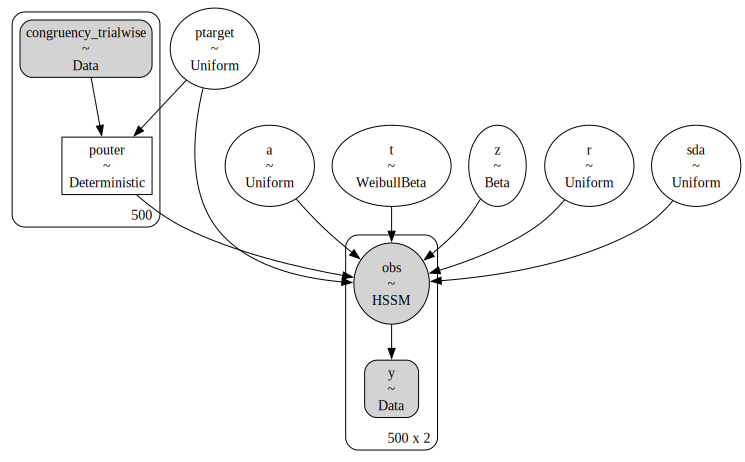

In [20]:
pm.model_to_graphviz(model_2)

### Sample and Plot

In [21]:
with model_2:
    idata_2 = pm.sample(tune = 500,
                        draws = 500,
                        chains = 2,
                        nuts_sampler = "numpyro",
                        var_names = [rv.name for rv in model_2.free_RVs] 
                        )

/Users/afengler/miniconda3/envs/hssm519/lib/python3.11/site-packages/pymc/sampling/jax.py:437: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 1000/1000 [00:18<00:00, 52.69it/s, 23 steps of size 1.87e-01. acc. prob=0.94]
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Sample diagnostics

In [22]:
az.summary(idata_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.435,0.087,1.281,1.584,0.005,0.003,385.0,419.0,1.01
ptarget,2.611,0.146,2.356,2.883,0.007,0.005,409.0,472.0,1.01
r,0.033,0.011,0.013,0.050,0.000,0.000,847.0,542.0,1.00
sda,2.422,0.278,1.956,2.955,0.012,0.008,526.0,491.0,1.00
t,0.320,0.022,0.283,0.361,0.001,0.001,436.0,477.0,1.01
z,0.541,0.015,0.511,0.564,0.001,0.000,475.0,449.0,1.00


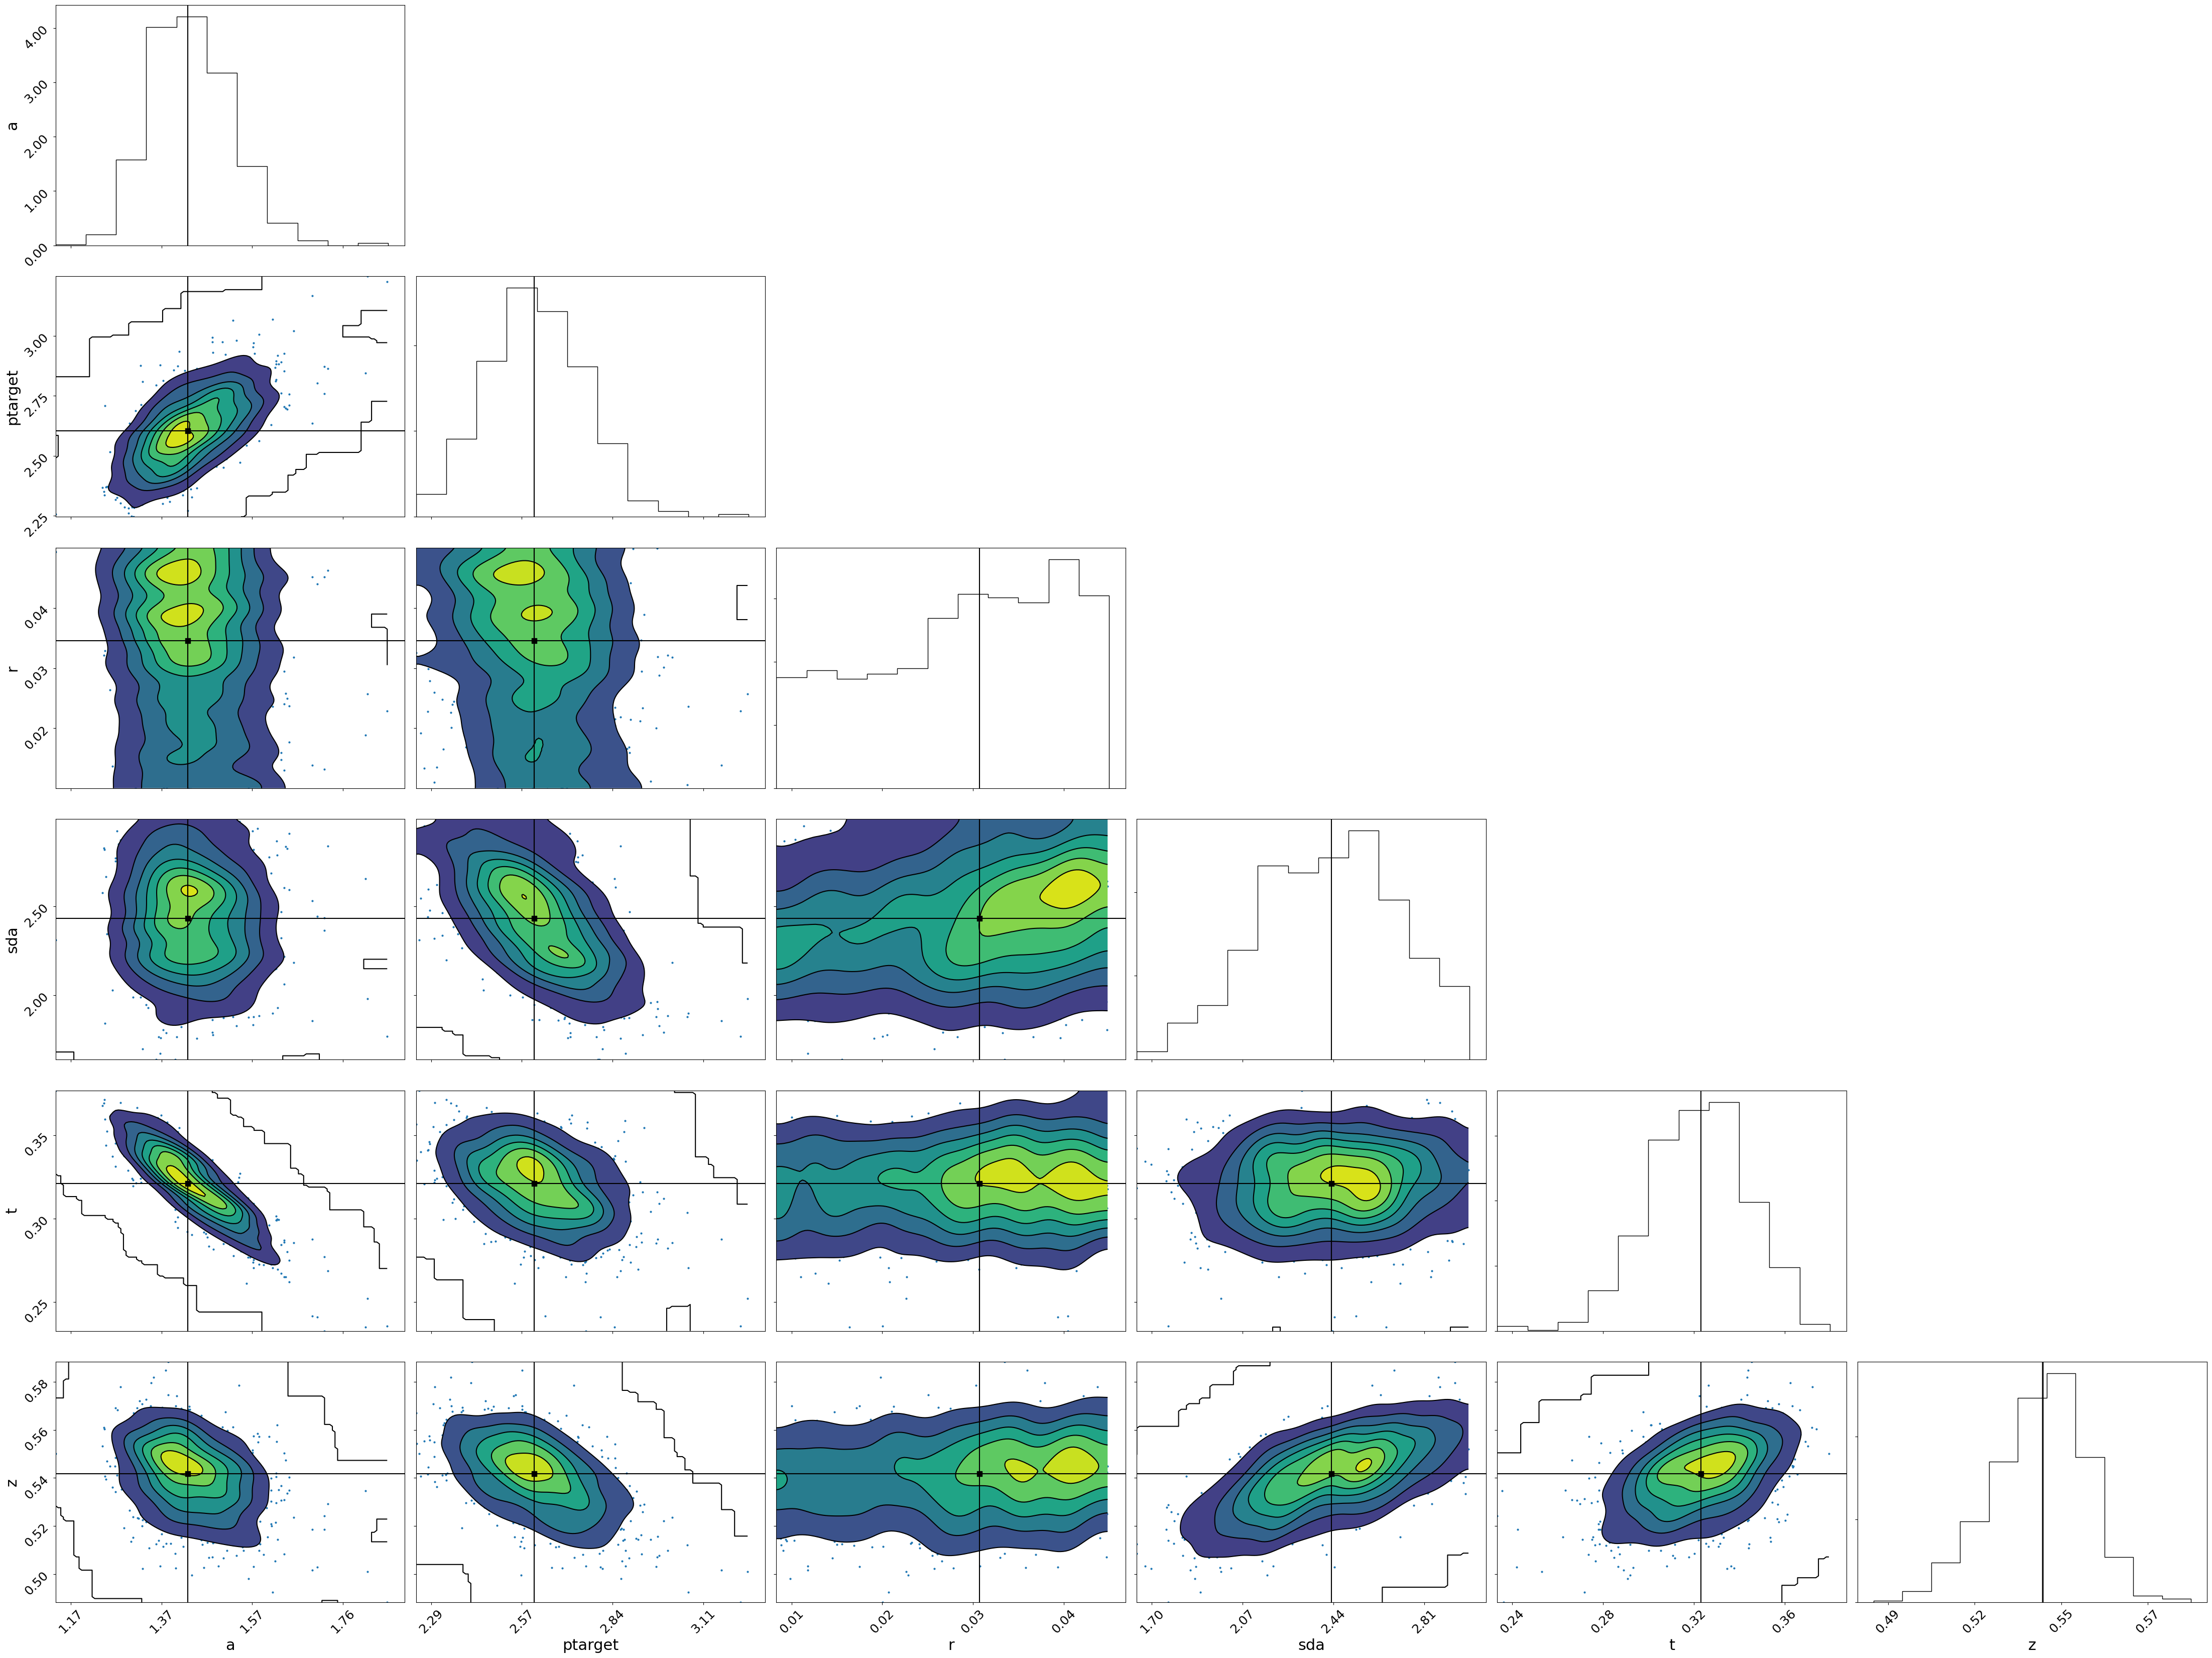

In [23]:
# Pair plot
ax = az.plot_pair(idata_2, 
                  kind=['kde', 'scatter'],
                  marginals=True,
                  kde_kwargs={"fill_last": False},
                  marginal_kwargs={"kind": "hist",
                                    "color": "black",
                                    "hist_kwargs": {"histtype": "step"},
                  },
                  point_estimate="median");


# Some extra formatting
[ax_i.tick_params(axis='x', rotation=45, labelsize=18) or \
 ax_i.tick_params(axis='y', rotation=45, labelsize=18) or \
 ax_i.locator_params(axis='x', nbins=5)  or \
 ax_i.locator_params(axis='y', nbins=5)  or \
 ax_i.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) or \
 ax_i.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) or \
 ax_i.set_xlabel(ax_i.get_xlabel(), fontsize=22)
 for ax_i in ax.ravel() if ax_i is not None]

# Then handle y-labels separately for the leftmost plots
[ax[i, 0].set_ylabel(ax[i, 0].get_ylabel(), fontsize=22) 
 for i in range(len(ax)) if ax[i, 0] is not None]
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>], dtype=object)

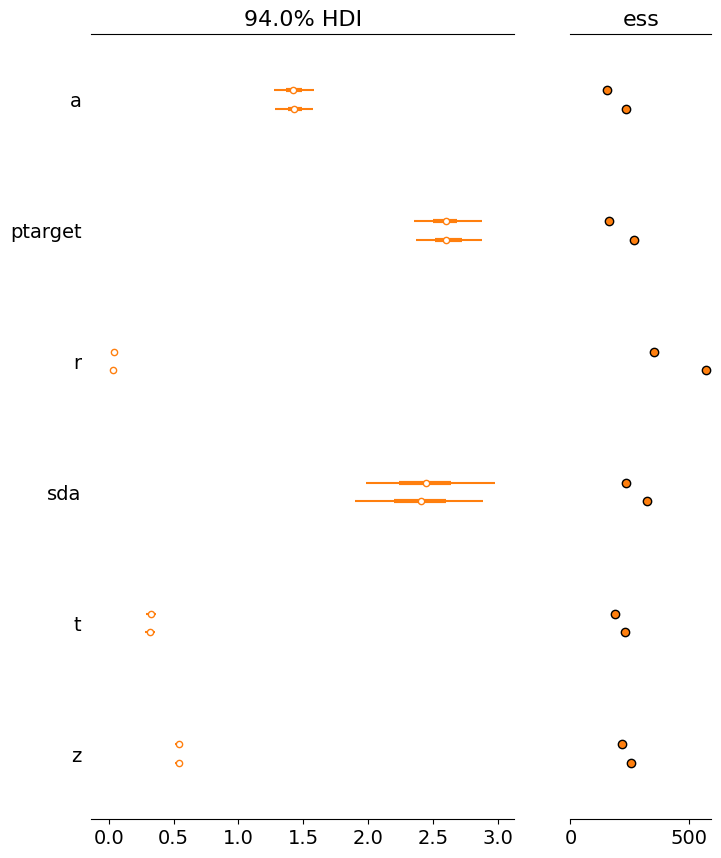

In [24]:
az.plot_forest(idata_2,
               colors = "C1",
               ess=True)

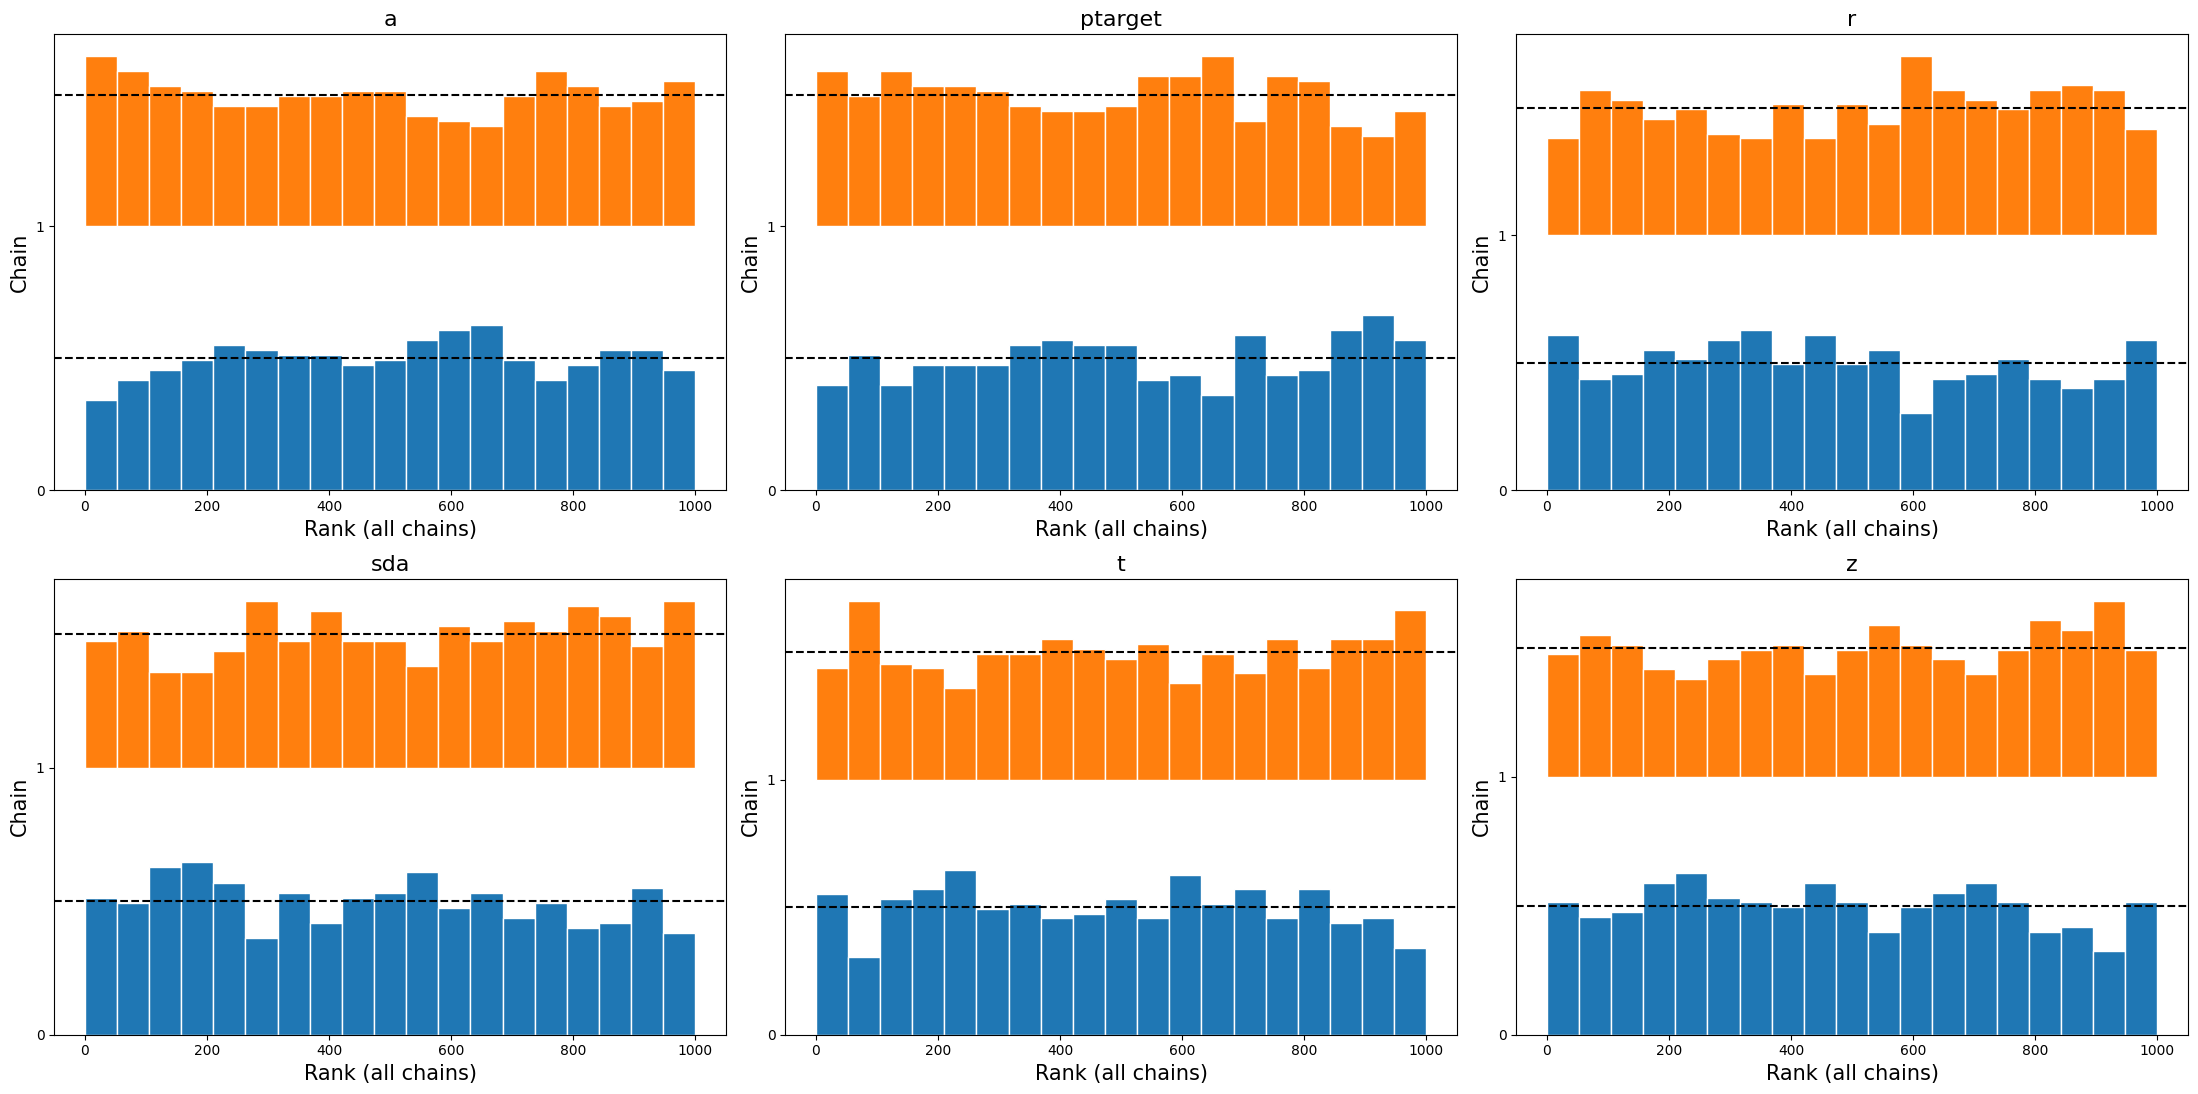

In [25]:
az.plot_rank(idata_2)
plt.tight_layout()

## Using the `do` operator (for later)

## Path forward:

We can now use our Random Variable to construct a very large amount of models directly via PyMC.
Once we have some experimental data, we can start playing around on that front.